# AlexNet CIFAR-100

# Resources
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://blog.paperspace.com/alexnet-pytorch/
- https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py
- https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
- https://en.wikipedia.org/wiki/AlexNet
- http://d2l.ai/chapter_convolutional-modern/alexnet.html
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

# Imports

In [1]:
# import pandas as pd # dataframes
# import torchvision.transforms as transforms

import os
import time
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchmetrics
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard.writer import SummaryWriter # http://localhost:6006/ # tensorboard --logdir=runs # https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

# Device Configuration

In [2]:
neural_net = "AlexNet"
dataset = "CIFAR-100"
run_directory = f"runs/{neural_net}-{dataset}"
dir = './data'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} processing")

#torch.set_default_dtype(torch.float16)

Using cuda processing


# Hyperparameters, Loss Function & Metrics

In [3]:
batch_size = 32

epoch_tuning_limit = 3 # number of epochs to go for when tuning the hyperparameters
epoch_training_limit = 20 # number of epochs to go for when full training

learning_rates_tuning = [0.01, 0.005, 0.001,  0.0005, 0.0001] # learning rates to tune
#learning_rates_adam = [] # to be determined by tuning
#learning_rates_sgd = [] # to be determined by tuning

loss_function = nn.CrossEntropyLoss() # Loss function to use

if dataset == 'CIFAR-10':
    classes = 10
elif dataset == 'CIFAR-100':
    classes = 100

metric_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=classes, average='macro').to(device) # https://www.evidentlyai.com/classification-metrics/multi-class-metrics#:~:text=Macro%2Daveraging%20shows%20average%20performance,and%20accuracy%20are%20the%20same.
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = classes, average='macro').to(device) # https://stackoverflow.com/questions/37358496/is-f1-micro-the-same-as-accuracy

# Load Datasets

In [4]:
if neural_net == 'AlexNet':
  resize = (224,224)  # resize images to 224x224
  num_workers = 4
elif neural_net == 'LeNetRGB':
  resize = (32,32)
  num_workers = 6 # LeNet is much lighter on CPU usage, allowing for more workers 

transform = transforms.Compose( # define normalization transform
    [
      transforms.Resize(resize),
      transforms.ToTensor(), # transform image to tensor and torch format
      transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)) # apply normalize across all the channels for the image
      # mention why 0.5
    ]
)

# Get Datasets
download = True
if dataset == 'CIFAR-10':
  dataset_train = datasets.CIFAR10(root = dir, download=download, transform=transform, train = True)
  dataset_test = datasets.CIFAR10(root = dir, download=download, transform=transform, train = False)
elif dataset == 'CIFAR-100':
  dataset_train = datasets.CIFAR100(root = dir, download=download, transform=transform, train = True)
  dataset_test = datasets.CIFAR100(root = dir, download=download, transform=transform, train = False)
class_names = dataset_train.classes

# Split the training dataset into a training set (90% samples) and a validation set (10% samples).
size_train = int(0.9 * len(dataset_train))
size_valid = len(dataset_train) - size_train

dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train, [size_train, size_valid])

#from torch.utils.data import Subset # massively shortening training times to allow for testing of graphs
#dataset_train = Subset(dataset_train, range(1000))
#dataset_valid = Subset(dataset_valid, range(1000))
#dataset_test = Subset(dataset_test, range(1000))

# Data loaders split the data up into batches as determined by the batch size
loader_train = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = True, num_workers=num_workers, pin_memory=True)
loader_valid = torch.utils.data.DataLoader(dataset = dataset_valid, batch_size = batch_size, shuffle = False, num_workers=num_workers, pin_memory=True)
loader_test = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle = False, num_workers=num_workers, pin_memory=True)

# Verify the sizes of the training and validation sets
print(f"Training Size: {len(dataset_train)}")
print(f"Validation Size: {len(dataset_valid)}")
print(f"Testing Size: {len(dataset_test)}")
print(f'Num Classes: {len(class_names)}')

Files already downloaded and verified
Files already downloaded and verified
Training Size: 45000
Validation Size: 5000
Testing Size: 10000
Num Classes: 10


# Explore and Visualize Data
- We do basic data analysis on the dataset.
- As we are working with the CIFAR dataset, we can see that each image is an RBG image, with a single object as the focus.
- This object maps to one of the classes the CIFAR dataset

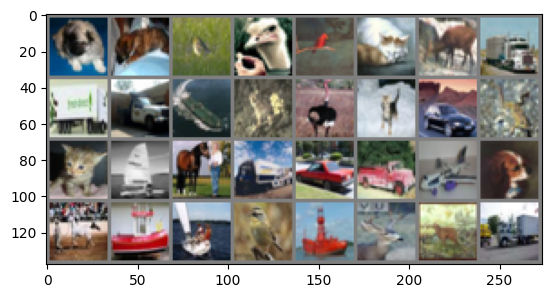

tensor([5, 5, 2, 2, 2, 3, 4, 9, 9, 9, 8, 6, 2, 3, 1, 6, 3, 8, 7, 9, 1, 9, 0, 5,
        7, 8, 8, 2, 8, 4, 4, 9])


In [5]:
def DisplayImage(image): # Normalize and display the image
    image = image / 2 + 0.5 # unnormalize
    npImage = image.numpy() # Convert the image tensor to a NumPy array
    plt.imshow(np.transpose(npImage, (1, 2, 0)))
    plt.show() # display

dateIterator = iter(loader_train)
images, labels = next(dateIterator)

DisplayImage(torchvision.utils.make_grid(images))
print(labels) # to do

# mean color distribtion, distribution of classes 
# https://medium.com/@sehjadkhoja0/title-exploring-and-analyzing-image-data-with-python-79a7f72f4d2b

# Model Architecture
- We use the preset AlexNet model provided by PyTorch.

In [6]:
model = models.AlexNet(num_classes=classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Define Training Function

## Model Wrapper
- We define a wrapper for our model that will help in storing, organzing, and persisting both the model and various metrics

In [7]:
class ModelWrapper:
    def __init__(self, optimizer, batch_size, num_epochs, learning_rate):
        self.log_dir = f'{run_directory}/{optimizer}-{batch_size}BS-{num_epochs}E-{learning_rate}LR'
        self.writer = SummaryWriter(log_dir=self.log_dir)

        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = num_epochs
        self.learning_rate = learning_rate

        self.losses_train_step = [] # loss for a step during model training
        self.losses_train = [] # average loss on the training dataset for an epoch
        self.losses_valid = [] # loss on the validation dataset after an epoch
        self.loss_test = 0 # loss on the test dataset after a full training loop
        
        self.accuracy_train = [] # average accuracy on the training dataset for an epoch
        self.accuracy_valid = [] # accuracy on the validation dataset after an epoch
        self.accuracy_test = 0 # accuracy on the test dataset after a full training loop
        
        self.f1_train = [] # average f1 score on the training dataset for an epoch
        self.f1_valid = [] # f1 score on the validation dataset after an epoch
        self.f1_test = 0 # f1 score on the test dataset after a full training loop

        self.start_time = time.time()
        self.end_time = time.time()

        self.best_time = None
        self.best_epoch = -1
        self.best_accuracy_valid = -1
        self.best_model_state = None
    
    def UpdateBestModel(self, model, at_epoch, validation_accuracy):
        self.best_time = time.time()
        self.best_model_state = copy.deepcopy(model.state_dict())
        self.best_epoch = at_epoch
        self.best_accuracy_valid = validation_accuracy
        
    def RunTime(self):
        return self.end_time - self.start_time

    def PrintEpochs(self):
        print(f'Trained model with learning rate {self.learning_rate}, for {self.epochs} epochs, using the {self.optimizer} optimizer. {self.RunTime():.2f} seconds.')
        for epoch in range(self.epochs):
            print(f'Epoch {epoch+1}; Valid Loss {self.losses_valid[epoch]:.4f}; '
                  + f'Valid Loss: {self.losses_valid[epoch]:.4f}; '
                  + f'Valid Accuracy: {(100 * self.accuracy_valid[epoch]):.4f}%; ' 
                  + f'Valid F1: {(100 * self.f1_valid[epoch]):.4f}%')
    
    def PrintFinal(self):
        print(f'Trained model with learning rate {self.learning_rate}, for {self.epochs} epochs, using the {self.optimizer} optimizer. {self.RunTime():.2f} seconds.')
        print(f'Final Train Loss:       {(self.losses_train[-1]):.4f};     ', end = '')
        print(f'Final Valid Loss:       {(self.losses_valid[-1]):.4f}')
        print(f'Final Train Accuracy:   {(100 * self.accuracy_train[-1]):.4f}%;      ', end = '')
        print(f'Final Valid Accuracy:   {(100 * self.accuracy_valid[-1]):.4f}%')
        print(f'Final Train F1:         {(100 * self.f1_train[-1]):.4f}%;        ', end = '')
        print(f'Final Valid F1:         {(100 * self.f1_valid[-1]):.4f}%')

In [8]:
def TrainModel(optimizer_choice, batch_size, learning_rate, num_epochs, printStep = False, pretrained = False, save_best_model = False):
  torch.cuda.empty_cache()
  
  # Model
  if pretrained:
    model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
    model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, classes).to(device) # pretrained AlexNet is meant to output 1000
  else:
    model = models.AlexNet(num_classes=classes).to(device)

  # Wrapper
  wrapper = ModelWrapper(optimizer=optimizer_choice, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate)

  # Optimizer Function
  # this will help change the parameters of the model, influenced by the learning rate
  if optimizer_choice == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  elif optimizer_choice == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
  else:
    return

  # For Epoch
  for epoch in range(num_epochs):

    loss_total = 0.0 # represents summation of the loss at each step for the validation dataset
    metric_accuracy.reset()
    metric_f1.reset()
    for i, (inputs, targets) in enumerate(loader_train): # loop through each batch the dataloader has
      inputs = inputs.to(device) # the input images from the training dataset 
      targets = targets.to(device) # the class labels from the training dataset 

      optimizer.zero_grad() # Zero the parameter gradients

      outputs = model(inputs) # feed the model the inputs, and get predictions off the inputs
      loss = loss_function(outputs, targets) # compare the preditions to the actual target values of the inputs
      loss.backward() # compute the gradients
      optimizer.step() # actually update the model parameters based off the gradients computed previously

      predicted = torch.argmax(outputs.data, 1) # get the highest classification value
      metric_accuracy.update(predicted, targets) # update the accuracy with the current step info
      metric_f1.update(predicted, targets) # update the f1 with the current step info
      
      loss_total += loss.item() # add the step loss to the total loss
      wrapper.losses_train_step.append(loss.item()) # update loss training step

      if printStep and (i%(round((len(loader_train)/3), -1)) == 0):
        print(f'LR: {learning_rate}; Opt: {optimizer}; Epoch {epoch+1}/{num_epochs}; Step: {i+1}/{len(loader_train)}; Loss: {loss.item():.4f}')
        print()

    loss_average = loss_total / len(loader_valid) # calculate the average loss for the validation dataset this epoch
    accuracy_val = metric_accuracy.compute().item() # calculate the accuracy for the validation dataset this epoch
    f1_val = metric_f1.compute().item() # calculate the f1 score for the validation dataset this epoch

    wrapper.losses_train.append(loss_average) # update valid loss epoch
    wrapper.accuracy_train.append(accuracy_val) # update valid accuracy epoch
    wrapper.f1_train.append(f1_val) # update valid f1 epoch

    wrapper.writer.add_scalar(f"Loss/Train/{num_epochs}E", loss_average, epoch) # update tensorboard
    wrapper.writer.add_scalar(f"Accuracy/Train/{num_epochs}E", accuracy_val, epoch) # update tensorboard
    wrapper.writer.add_scalar(f"F1/Train/{num_epochs}E", f1_val, epoch) # update tensorboard
    
    model.eval() # set the model to eval mode so it does not train off the whole training/testing sets
    with torch.no_grad(): # disabling gradient calculation, since we're not computing gradients # get the validation dataset metrics
      loss_total = 0.0 # represents summation of the loss at each step for the validation dataset
      metric_accuracy.reset()
      metric_f1.reset()
      for inputs, targets in loader_valid: 
        inputs = inputs.to(device) # input images from the validation dataset
        targets = targets.to(device) # get the classes of the test input
        outputs = model(inputs) # predict the classification values of the test input
        predicted = torch.argmax(outputs.data, 1) # get the highest classification value

        loss = loss_function(outputs, targets) # compute the loss of the step
        loss_total += loss.item() # add the step loss to the total loss

        metric_accuracy.update(predicted, targets) # update the accuracy with the current step info
        metric_f1.update(predicted, targets) # update the f1 with the current step info

      loss_average = loss_total / len(loader_valid) # calculate the average loss for the validation dataset this epoch
      accuracy_val = metric_accuracy.compute().item() # calculate the accuracy for the validation dataset this epoch
      f1_val = metric_f1.compute().item() # calculate the f1 score for the validation dataset this epoch

      if save_best_model and (accuracy_val > wrapper.best_accuracy_valid): # best model
        wrapper.UpdateBestModel(model=model, at_epoch=epoch, validation_accuracy=accuracy_val)

      wrapper.losses_valid.append(loss_average) # update valid loss epoch
      wrapper.accuracy_valid.append(accuracy_val) # update valid accuracy epoch
      wrapper.f1_valid.append(f1_val) # update valid f1 epoch
      
      wrapper.writer.add_scalar(f"Loss/Valid/{num_epochs}E", loss_average, epoch) # update tensorboard
      wrapper.writer.add_scalar(f"Accuracy/Valid/{num_epochs}E", accuracy_val, epoch) # update tensorboard
      wrapper.writer.add_scalar(f"F1/Valid/{num_epochs}E", f1_val, epoch) # update tensorboard

    model.train() # set model back in training mode

  wrapper.writer.flush()
  wrapper.end_time = time.time()
  return wrapper

# Hyperparameter Tuning
- We train multiple models from the tuning learning rate values both optimizers over a limited number of epochs.
- We will select the two most promising learning rates for each optimizer and run those learning rates to the specified epoch training limit

In [9]:
print(f'Training {len(learning_rates_tuning)} learning rates for both Adam and SGD loss functions over {epoch_tuning_limit} epochs.')
time_tuning_start = time.time()

models_tuning_adam = []
for learning_rate in learning_rates_tuning:
  models_tuning_adam.append(TrainModel(optimizer_choice='Adam', batch_size=batch_size, num_epochs=epoch_tuning_limit, learning_rate=learning_rate))

models_tuning_sgd = []
for learning_rate in learning_rates_tuning:
  models_tuning_sgd.append(TrainModel(optimizer_choice='SGD', batch_size=batch_size, num_epochs=epoch_tuning_limit, learning_rate=learning_rate))

time_tuning_end = time.time()
time_tuning = time_tuning_end - time_tuning_start

print(f"Training finished, elapsed time: {time_tuning:.2f} seconds ({(time_tuning/60):.2f} minutes)")

Training 5 learning rates for both Adam and SGD loss functions over 3 epochs.


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

## Selecting Learning Rates for Each Optimizer
- See which learning rates provide the highest validation accuracy after the specified number of tuning epochs.
- Select two learning rates which result in the highest validation accuracy.

In [ ]:
print('Adam Metrics')
for metrics in models_tuning_adam:
    metrics.PrintFinal()
    print()

print('SGD Metrics')
for metrics in models_tuning_sgd:
    metrics.PrintFinal()
    print()

learning_rate_adam = max(models_tuning_adam, key=lambda x: x.accuracy_valid[-1]).learning_rate
learning_rate_sgd = max(models_tuning_sgd, key=lambda x: x.accuracy_valid[-1]).learning_rate

print(f'Adam LR: {learning_rate_adam}')
print(f'SGD LR: {learning_rate_sgd}')

# Train Models
- We train the selected learning rates for both optimizers to the number of epochs defined by the epoch_training_limit

In [ ]:
print(f'Training two models over {epoch_training_limit} epochs.')
time_training_start = time.time()

model_adam = TrainModel(optimizer_choice='Adam', batch_size=batch_size, num_epochs=epoch_training_limit, learning_rate=learning_rate_adam, save_best_model=True)
model_sgd = TrainModel(optimizer_choice='SGD', batch_size=batch_size, num_epochs=epoch_training_limit, learning_rate=learning_rate_sgd, save_best_model=True)

time_training_end = time.time()
time_training = time_training_end - time_training_start

print(f"Training finished, elapsed time: {time_training:.2f} seconds ({(time_training/60):.2f} minutes)")

In [ ]:
print('Adam Metrics')
model_adam.PrintEpochs()
print()

print('SGD Metrics')
model_sgd.PrintEpochs()
print()

## Persist Model and Metrics
- Since training can takes upwards of an hour, we persist and save the model state dictionary and various metrics.
- This is done so we can use the data gotten over training without needing to do an other training cycle.

In [ ]:
directory = f'models/{neural_net}-{dataset}'
if not os.path.exists(directory):
    os.makedirs(directory)

def SerializeWrapper(wrapper, filename):
    filename = f'{directory}/{filename}'
    state_copy = copy.deepcopy(wrapper.best_model_state)

    torch.save(wrapper.best_model_state, f'{filename}.pth')
    wrapper.best_model_state = None
    wrapper.writer = None
    with open(filename+'.wrapper', 'wb') as f:
        pickle.dump(wrapper, f)
    wrapper.best_model_state = state_copy

def DeserializeWrapper(filename):
    filename = f'{directory}/{filename}'
    with open(filename+'.wrapper', 'rb') as f:
        wrapper = pickle.load(f)
    wrapper.best_model_state = torch.load(f'{filename}.pth')
    return wrapper

In [ ]:
if 'model_adam' in globals():
    print('Serialized Adam')
    SerializeWrapper(model_adam, 'best_adam')
if 'model_sgd' in globals():
    print('Serialized SGD')
    SerializeWrapper(model_sgd, 'best_sgd')
if not 'model_adam' in globals():
    print('Deserialized Adam')
    model_adam = DeserializeWrapper('best_adam')
if not 'model_sgd' in globals():
    print('Deserialized SGD')
    model_sgd = DeserializeWrapper('best_sgd')

for wrapper in [model_adam, model_sgd]:
    print(f'{wrapper.optimizer} optimizer with learning rate {wrapper.learning_rate}')
    print(f'Model performance peaked at epoch {wrapper.best_epoch}.')

# Evaluate Model Accuracy
- We evaluate the accuracy of the model on both the training and validation datasets.
- We compare the accuracy of the selected learning rates within each optimizer.
- We compare the accuracy of the two optimizers against each other

## Define Plot Functions

In [ ]:
def PlotAccuracy(wrapper):
    plt.close()
    range_epochs = range(1, epoch_training_limit+1)
    
    plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_train], label=f'Training') # training accuracy
    plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_valid], label=f'Validation') # validation accuracy

    plt.suptitle(f'{neural_net}-{dataset}') # Super Title
    plt.title(f'{wrapper.optimizer} optimizer using learning rate: {wrapper.learning_rate}') # Title
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)
    plt.grid(True)

    plt.xlabel('Epochs')
    plt.xlim(1, epoch_training_limit)
    plt.xticks(range_epochs)

    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)

    plt.show()

In [ ]:
def PlotCompareAccuracy(wrappers):
    plt.close()
    range_epochs = range(1, epoch_training_limit+1)
    
    for wrapper in wrappers:
        plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_train], label=f'Optimal {wrapper.optimizer} Training') # training accuracy
        plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_valid], label=f'Optimal {wrapper.optimizer} Validation') # validation accuracy
    # test set loss

    plt.suptitle(f'{neural_net}-{dataset}') # Super Title
    plt.title(f'Comparing Adam vs SGD optimizers') # Title
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)
    plt.grid(True)

    plt.xlabel('Epochs')
    plt.xlim(1, epoch_training_limit)
    plt.xticks(range_epochs)

    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)

    plt.show()
    

## Adam Optimizer Metrics

In [ ]:
PlotAccuracy(model_adam)

## SGD Optimizer Metrics

In [ ]:
PlotAccuracy(model_sgd)

## Adam vs SGD Accuracy

In [ ]:
PlotCompareAccuracy([model_adam, model_sgd])

# Predictions on Test Set
- We get the loss, the accuracy, and the F1 score of the model against the test set.
- These are not definitive metrics, as the test set is only evaluated after fully training the model as defined by epoch_test_limit.
- This means that the model could have overfitted by the number of epochs specified.

In [ ]:
def PredictTestSet(wrapper):
    model = models.AlexNet(num_classes=classes)
    model.load_state_dict(wrapper.best_model_state)
    model = model.to(device)

    print(f'Copied best model at {wrapper.best_epoch} epoch for {wrapper.optimizer} optimizer, using LR: {wrapper.learning_rate}')
    print(f'Best Accuracy: {(100 * wrapper.best_accuracy_valid):.2f}%')
    with torch.no_grad():
        loss_total = 0.0
        metric_accuracy.reset()
        metric_f1.reset()

        for inputs, targets in loader_test:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)

            loss = loss_function(outputs, targets)
            loss_total += loss.item()

            metric_accuracy.update(predicted, targets)
            metric_f1.update(predicted, targets)

        wrapper.loss_test = loss_total / len(loader_test)
        wrapper.accuracy_test = metric_accuracy.compute().item()
        wrapper.f1_test = metric_f1.compute().item()

In [ ]:
for wrapper in [model_adam, model_sgd]:
    PredictTestSet(wrapper)

for wrapper in [model_adam, model_sgd]:
    print(f'Opt: {wrapper.optimizer}; LR: {wrapper.learning_rate}')
    print(wrapper.loss_test)
    print(wrapper.accuracy_test)
    print(wrapper.f1_test)
    print()

# Export Graphs for Report
- Loss/Epoch
- Accuracy/Epoch
- F1/Epoch
- Loss/Step
    

In [ ]:
xticks_val = [1, 5, 10, 15, 20]
range_epochs = range(1, epoch_training_limit+1)

for wrapper in (model_adam, model_sgd): # Training and Valid Loss
    plt.close()
    
    plt.plot(range_epochs, wrapper.losses_train, label='Training Loss', color='blue')
    plt.plot(range_epochs, wrapper.losses_valid, label='Validation Loss', color='red')

    plt.xlabel('Epochs')
    plt.xlim(1, epoch_training_limit)
    plt.xticks(xticks_val)

    plt.ylabel('Loss')
    
    plt.suptitle(f'{neural_net}-{dataset}') # Super Title
    plt.title(f'{wrapper.optimizer} Optimizer with Learning Rate {wrapper.learning_rate}') # Title
    plt.legend()

    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-loss-epoch.png')

for wrapper in (model_adam, model_sgd): # Validation Accuracy
    plt.close()

    plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_train], label='Training Accuracy', color='blue')
    plt.plot(range_epochs, [value * 100 for value in wrapper.accuracy_valid], label='Validation Accuracy', color='red')

    plt.title(f'{wrapper.optimizer} Optimizer with Learning Rate {wrapper.learning_rate}')
    plt.suptitle(f'{neural_net}-{dataset}')

    plt.xlabel('Epochs')
    plt.xlim(1, epoch_training_limit)
    plt.xticks(xticks_val)

    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)

    plt.legend()

    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-acc-epoch.png')

# F1 Score/Epoch
for wrapper in (model_adam, model_sgd):
    plt.close()

    plt.plot(range_epochs, [value * 100 for value in wrapper.f1_train], label='Training F1 Score', color='blue')
    plt.plot(range_epochs, [value * 100 for value in wrapper.f1_valid], label='Validation F1 Score', color='red')

    plt.title(f'{wrapper.optimizer} Optimizer with learning rate {wrapper.learning_rate}')
    plt.suptitle(f'{neural_net}-{dataset}')

    plt.xlabel('Epochs')
    plt.xlim(1, epoch_training_limit)
    plt.xticks(xticks_val)

    plt.ylabel('F1 Score (%)')
    plt.ylim(0, 100)

    plt.legend()

    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-f1-epoch.png')

for wrapper in (model_adam, model_sgd): # Training Loss/Step
    plt.close()
    
    # Data
    range_steps = range(1, len(wrapper.losses_train_step)+1)
    plt.plot(range_steps, wrapper.losses_train_step, label='Training Loss/Steps', color='blue')

    plt.xlabel('Steps')
    plt.xlim(1, len(wrapper.losses_train_step))

    plt.ylabel('Loss')
    
    plt.suptitle(f'{neural_net}-{dataset}') # Super Title
    plt.title(f'{wrapper.optimizer} Optimizer with learning rate {wrapper.learning_rate}') # Title
    plt.legend()

    #plt.show()
    plt.savefig(f'out/{neural_net}-{dataset}/{wrapper.optimizer}/{wrapper.learning_rate}-loss-step.png')